# X-shaped race graphs

Reading, I saw the statistic that a South-side Chicago neighborhood went from 90% white to 95% black in 30 years. If you graphed black and white population on a line, they'd cross in the middle like an X.

I wondered if there were any interesting recent cases of that kind of shift, and decided to see how easy that is with [Census Reporter](https://censusreporter.org). This is a mostly through-composed notebook, with a little cleanup. Maybe it's useful to other folks, or at least to me when I'm trying to remember how I did something...

## To begin...

Census Reporter has [an API](https://api.censusreporter.org) but it only serves the most recent ACS. Since we're talking historical comparison, that isn't going to do it for this.

However, we've created [postgres database dumps for all ACS data released so far](http://censusreporter.tumblr.com/post/73727555158/easier-access-to-acs-data) so that other people can use the data with less setup.

This is not what most people would call easy, but it is straightforward once you have the tools installed. Instructions about installing postgres is out of scope here, but if you created a database on a running postgres server, the rest really is pretty easy.

This assumes you created a database named `census` already.

## Download the data


The ACS 1-year database dumps are less than 500 MB, so dealing with them is pretty fast. The ACS 5-year database dumps are very large, and you should only mess with them if you need them for more than one project.

To download the data, do something like this:

```bash
curl -O http://census-backup.s3.amazonaws.com/acs/2007/acs2007_1yr/acs2007_1yr_backup.sql.gz
curl -O http://census-backup.s3.amazonaws.com/acs/2014/acs2014_1yr/acs2014_1yr_backup.sql.gz    
```

Then, assuming you have created a database named `census` and that you don't need to specify any username, password or other connection details, do this:

```bash
gzcat acs2007_1yr_backup.sql.gz | psql census
gzcat acs2014_1yr_backup.sql.gz | psql census
```

These take a few minutes, so be patient, and probably best to paste the lines one-at-a-time.

But now we're ready to code. 

### connect to the database

In [1]:
import pandas as pd
from psycopg2 import connect
con = connect(database='census')

### execute queries

We want to consider race, which is a complicated subject, including in how the Census deals with it. At least for the span of the ACS, the questions are the same -- comparing back even just in the last few decades may mean a detour to brush up on how to compare when the questions were asked differently.


You might start looking for the data we need in the Census Bureau's tables in the "race" topic. However, latino is counted as an "ethnicity," and there's a separate topic for the tables which report that data. The best table for our analysis is [B03002: Hispanic or Latino Origin by Race](http://censusreporter.org/tables/B03002/)

Here's how to read in that table from the two different Census years:

In [2]:
# We leave out summary level 500 -- congressional districts -- because they changed considerably between
# 2007 and 2014.
sql = """
select g.name, d.* 
from {schema}.geoheader g, {schema}.b03002 d
where g.geoid = d.geoid
and g.sumlevel != 500
"""

b03002_14 = pd.read_sql_query(sql.format(schema='acs2014_1yr'), con, index_col='geoid')
b03002_07 = pd.read_sql_query(sql.format(schema='acs2007_1yr'), con, index_col='geoid')

### simplify the data

When talking about race in the United States, the set of "options" is often boiled down to:

* White
* Black
* Asian
* Hispanic

On a national level, this covers more than 95% of the population. Since we're looking at sub-national data, we shouldn't assume that the other categories aren't relevant, but we still, there are 22 columns in B03002, and that's a lot to deal with. 

<ul>
    <li><em>b03002001:</em> Total:<ul>
        <li><em>b03002002:</em> Not Hispanic or Latino:<ul>
            <li><em>b03002003:</em> White alone</li>
            <li><em>b03002004:</em> Black or African American alone</li>
            <li><em>b03002005:</em> American Indian and Alaska Native alone</li>
            <li><em>b03002006:</em> Asian alone</li>
            <li><em>b03002007:</em> Native Hawaiian and Other Pacific Islander alone</li>
            <li><em>b03002008:</em> Some other race alone</li>
            <li><em>b03002009:</em> Two or more races:<ul>
                <li><em>b03002010:</em> Two races including Some other race</li>
                <li><em>b03002011:</em> Two races excluding Some other race, and three or more races</li>
            </ul></li>
        </ul></li>
        <li><em>b03002012:</em> Hispanic or Latino:<ul>
            <li><em>b03002013:</em> White alone</li>
            <li><em>b03002014:</em> Black or African American alone</li>
            <li><em>b03002015:</em> American Indian and Alaska Native alone</li>
            <li><em>b03002016:</em> Asian alone</li>
            <li><em>b03002017:</em> Native Hawaiian and Other Pacific Islander alone</li>
            <li><em>b03002018:</em> Some other race alone</li>
            <li><em>b03002019:</em> Two or more races:<ul>
                <li><em>b03002020:</em> Two races including Some other race</li>
                <li><em>b03002021:</em> Two races excluding Some other race, and three or more races</li>
            </ul></li>
        </ul></li>
    </ul></li>
</ul>

(If you want to learn a little more about how race is handled in the ACS, check out [Census Reporter's "Race and Hispanic Origin" topic page](http://censusreporter.org/topics/race-hispanic/).)



For our purposes, we're going to count all Hispanic as a single group. For "non-hispanic", we'll collapse "some other race" and "two or more races" into "other". 


In [3]:
def simplifier(b03002,percentify=True):
    """Given a dataframe with B03002 schema, reduce it to a simpler dataframe according to the rules described above"""
    newcols = {
        'total': b03002['b03002001'],
        'white': b03002['b03002003'],
        'black': b03002['b03002004'],
        'amerind': b03002['b03002005'],
        'asian': b03002['b03002006'],
        'pacific': b03002['b03002007'],
        'other': b03002['b03002008'] + b03002['b03002009'],
        'hisp': b03002['b03002012']
    }
    if percentify:
        total = newcols.pop('total')
        for col in newcols:
            newcols[col] = newcols[col]/total
            
    return pd.DataFrame.from_dict(newcols)

race07 = simplifier(b03002_07)
race14 = simplifier(b03002_14)

race_chg = race14 - race07
race_chg = race_chg.dropna()

# it's nice to have the 'name' column at the front when spitting it out in the notebook. 
# Since we use the geoid for the dataframe index, we can comfortably mix and match data from different queries.
race_chg.insert(0,'name', b03002_07['name'])


### Identify the places with most change

So, which places had the biggest change in any given race? This is probably not a particularly savvy way to get that, but it gave me a chance to practice the `pandas` syntax for building up data for a `DataFrame` which isn't already assembled in a CSV or database table.

In [4]:
index=[]
summary = {'col':[],'value': [], 'name': []}
for col in race_chg.columns:
    if col != 'name':
        top = race_chg[col].max()
        bot = race_chg[col].min()
        if abs(top) > abs(bot):
            val = top
        else:
            val = bot
        row = race_chg[race_chg[col] == val]
        summary['col'].append(col)
        summary['value'].append(val)
        summary['name'].append(row['name'].item()) # we don't want the index label so use item()
        index.append(row.index.tolist()[0]) # here's where we want the index/geoid

summary = pd.DataFrame(summary,index=pd.Series(index,name='geoid'))
summary

,col,name,value
geoid,,,
79500US3500200,amerind,"PUMA5 00200, New Mexico",0.164586
79500US0608101,asian,"PUMA5 08101, California",0.428660
79500US0605500,black,"PUMA5 05500, California",-0.392138
79500US0400122,hisp,"PUMA5 00122, Arizona",0.607988
79500US4000100,other,"PUMA5 00100, Oklahoma",0.093469
40000US43669,pacific,"Kailua (Honolulu County)--Kaneohe, HI Urbanize...",-0.055974
79500US0400122,white,"PUMA5 00122, Arizona",-0.649215


## a diversion

Here I decided to try to get all the bits in a single dataframe, `race`. I don't remember why, but the merging didn't seem to work the way I expected at first. I may have just been making bonehead mistakes because now it looks fairly straightforward.

Then I was curious about the spread of changes. I could have (more) easily just described the `race_chg` dataframe, but sometimes you choose a step based on where you're stepping from so the last line here is just a trick to select only the `chg` columns from the merged dataframe for a quick look at them.

In [5]:
race = pd.merge(race07,race14,left_index=True,right_index=True,suffixes=('_07','_14'))
race = race.merge(race_chg,left_index=True,right_index=True,suffixes=('','_chg'))
race.insert(0,'name',race.pop('name'))
race['total_07'] = b03002_07['b03002001']
race['total_14'] = b03002_14['b03002001']
race = race.merge(race_chg,left_index=True,right_index=True,suffixes=('','_chg'))
race[[x for x in race.columns if x.endswith('_chg')]].describe()

,amerind_chg,asian_chg,black_chg,hisp_chg,other_chg,pacific_chg,white_chg
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,0.000148,0.008763,0.000057,0.024247,0.006655,0.000357,-0.040226
std,0.008454,0.021830,0.028130,0.048114,0.009439,0.003903,0.054326
min,-0.094654,-0.120585,-0.392138,-0.452918,-0.047881,-0.055974,-0.649215
25%,-0.001342,0.000975,-0.006942,0.011746,0.002171,-0.000352,-0.055862
50%,-0.000196,0.005339,0.000780,0.022289,0.005954,0.000000,-0.039391
75%,0.000879,0.012810,0.007866,0.036563,0.010856,0.000583,-0.024016
max,0.164586,0.428660,0.370986,0.607988,0.093469,0.047832,0.512265


I always like boxplots. These are pretty hard to read, but I still think they look cool, and I like how much they data they pack.

Matplotlib on MacOS with virtualenv is often a headache, but this seems to work consistently. Bokeh doesn't have built-in boxplots, so this is what we've got. 

/Users/germuska/.virtualenvs/notebooks/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


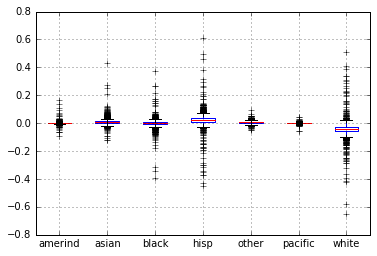

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
race_chg.plot(kind='box')

One conclusion I draw from some of these summaries is that the number of places with dramatic changes in the percent of native american, pacific islander, some other race and multiracial is few, so I'm leaving them out of the rest of the analysis.

## Using a visualization to see the extremes

It took me a bunch of time to get the tooltips going -- again, it seems simple now, but I was piecing bits together from online examples while translating, and it took some fiddling.

Most to the point, it seems like you can't add tools like the hover tool when you use the `Scatter` class.

I wanted to reduce the number of points plotted, so I decided to eliminate those which would cluster closest to the center line, which is essentially-no-change.  I omitted from the chart places in the data where the net change in population for the given group was less than 20 percentage points, either more or less. 


In [7]:
from bokeh.charts import Scatter, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, PolyAnnotation
from bokeh.models.sources import ColumnDataSource
output_notebook()

#scatterplot = Scatter(race, x='white_07', y='white_14', title="Pct white 2007 vs 2014",
#            xlabel="2007 pct white")
# http://blog.rtwilson.com/bokeh-plots-with-dataframe-based-tooltips/
hover = HoverTool(tooltips=[('name','@name'),
                            ('geoid', '@geoid'),
                            ('white', '@white_chg{1.11}'), 
                            ('black', '@black_chg{1.11}'),
                            ('hisp', '@hisp_chg{1.11}'),
                            ('asian', '@asian_chg{1.11}')])

p = figure(plot_width=750, plot_height=750,
           title="larger swings")
p.add_tools(hover)

_plot_configs = [
    ('white', 'red', 'circle'),
    ('black', 'blue', 'square'),
    ('hisp', 'green', 'triangle'),
    ('asian', 'brown', 'inverted_triangle')
]

for r, c, m in _plot_configs:
    x_col = (r+'_07')
    y_col = (r+'_14')
    chg_col = (r+'_chg')
    race_for_plot = race[(race[chg_col].abs() > 0.2)]
    p.scatter(x=x_col, y=y_col, size=10, color=c, marker=m, source=ColumnDataSource(race_for_plot), legend=chg_col)


p.xaxis.axis_label = '2007 pct of population'
p.yaxis.axis_label = '2014 pct'

# these just don't work!
# drop_anno = PolyAnnotation(plot=p, xs=[.2, .4, .4, .2], ys=[.2, .2, .4, .4], fill_alpha=0.1, fill_color='red')
#growth_anno = PolyAnnotation(plot=p, bottom=180, fill_alpha=0.1, fill_color='green')

#p.renderers.extend([drop_anno, ])

show(p)


Loading BokehJS ...

Details on formatting the tooltips for Bokeh are not super easy to find. I had to hunt around to figure out how to format the change floats to have only two decimal places. I'm still not sure what to do about really long names, like _Philadelphia, PA Metro Division; Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area_.

### Lists instead of Charts

Below are those places as a list, instead of on the chart. Broken up by race because again, I didn't come up with a clever way to say "any row where the absolute value of any of these values is greater than 0.2"

In [8]:
race[race['black_chg'].abs() > 0.2][['name','black_07','black_14','black_chg','total_07', 'total_14']]

,name,black_07,black_14,black_chg,total_07,total_14
geoid,,,,,,
79500US0605500,"PUMA5 05500, California",0.414126,0.021988,-0.392138,106581,141667
79500US2503303,"PUMA5 03303, Massachusetts",0.601772,0.258776,-0.342995,115710,112634
79500US2503304,"PUMA5 03304, Massachusetts",0.181944,0.552930,0.370986,117844,137728
79500US4802308,"PUMA5 02308, Texas",0.419891,0.106989,-0.312901,179311,105889
79500US4802504,"PUMA5 02504, Texas",0.054091,0.321509,0.267418,226857,104588
79500US4803501,"PUMA5 03501, Texas",0.034760,0.301364,0.266604,115420,166390
79500US4804625,"PUMA5 04625, Texas",0.008153,0.221798,0.213644,153925,114140


In [9]:
race[race['asian_chg'].abs() > 0.2][['name','asian_07','asian_14','asian_chg','total_07', 'total_14']]

,name,asian_07,asian_14,asian_chg,total_07,total_14
geoid,,,,,,
79500US0608101,"PUMA5 08101, California",0.041138,0.469799,0.428660,240360,149579
79500US0608102,"PUMA5 08102, California",0.082052,0.353831,0.271779,130844,122683
79500US0608103,"PUMA5 08103, California",0.011072,0.260809,0.249737,148930,104728
79500US2701303,"PUMA5 01303, Minnesota",0.030409,0.241126,0.210717,115230,135506


In [10]:
race[race['hisp_chg'].abs() > 0.2][['name','hisp_07','hisp_14','hisp_chg','total_07', 'total_14']]

,name,hisp_07,hisp_14,hisp_chg,total_07,total_14
geoid,,,,,,
79500US0400103,"PUMA5 00103, Arizona",0.186270,0.479699,0.293429,239088,112433
79500US0400109,"PUMA5 00109, Arizona",0.512736,0.197885,-0.314852,174813,111939
79500US0400115,"PUMA5 00115, Arizona",0.461815,0.245164,-0.216651,161229,104583
79500US0400117,"PUMA5 00117, Arizona",0.665978,0.368033,-0.297946,153493,108417
79500US0400118,"PUMA5 00118, Arizona",0.788194,0.541578,-0.246616,175321,114495
79500US0400119,"PUMA5 00119, Arizona",0.274150,0.658849,0.384699,148404,116957
79500US0400121,"PUMA5 00121, Arizona",0.171333,0.667758,0.496425,247273,143892
79500US0400122,"PUMA5 00122, Arizona",0.165037,0.773025,0.607988,139399,94724
79500US0601301,"PUMA5 01301, California",0.178530,0.493466,0.314936,135266,123269


In [11]:
race[race['white_chg'].abs() > 0.2][['name','white_07','white_14','white_chg','total_07', 'total_14']]

,name,white_07,white_14,white_chg,total_07,total_14
geoid,,,,,,
16000US4847892,"Mesquite city, Texas",0.528739,0.307210,-0.221530,126081,144289
31400US3798037964,"Philadelphia, PA Metropolitan Division, Philad...",0.662279,0.443912,-0.218367,3887694,2123257
79500US0400103,"PUMA5 00103, Arizona",0.728518,0.406740,-0.321778,239088,112433
79500US0400106,"PUMA5 00106, Arizona",0.755835,0.486296,-0.269539,95112,123398
79500US0400108,"PUMA5 00108, Arizona",0.755408,0.552054,-0.203354,120850,105593
79500US0400109,"PUMA5 00109, Arizona",0.354030,0.621428,0.267398,174813,111939
79500US0400115,"PUMA5 00115, Arizona",0.433080,0.652907,0.219828,161229,104583
79500US0400117,"PUMA5 00117, Arizona",0.178125,0.520038,0.341913,153493,108417
79500US0400119,"PUMA5 00119, Arizona",0.547667,0.133314,-0.414353,148404,116957
